# Preparations: Data & Package 

## Package

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.discriminant_analysis import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

np.random.seed(42)

## Functions Needed

In [5]:
def get_FM_data(data, option):
    # option in ("F","M")
    columns = data.columns
    fcols = columns[[c.startswith(option) for c in columns]]
    res = data[fcols].copy()
    res.columns=[c[1:] for c in fcols]
    return res
def wide_to_long(data):
    res = data.copy().reset_index()
    res.rename(columns={'index': 'user_id'}, inplace=True)
    long_data = pd.melt(res, id_vars=['user_id'], var_name='item_id', value_name='rating')
    return long_data

## Data Info & Cleaning

Loading Data

In [6]:
data = pd.read_excel("Ecommerce data.xlsx")
data.shape

(33713, 69)

Basic Info

In [7]:
print("Columns: \n",data.columns)
print("\nData shape: \n",data.shape)
data.head(3)

Columns: 
 Index(['id', 'logtarg', 'r', 'f', 'm', 'tof', 'Ffiction1', 'Fclassics3',
       'Fcartoons5', 'Flegends6', 'Fphilosophy7', 'Freligion8', 'Fpsychology9',
       'Flinguistics10', 'Fart12', 'Fmusic14', 'Ffacsimile17', 'Fhistory19',
       'Fconthist20', 'Feconomy21', 'Fpolitics22', 'Fscience23', 'Fcompsci26',
       'Frailroads27', 'Fmaps30', 'Ftravelguides31', 'Fhealth35', 'Fcooking36',
       'Flearning37', 'FGamesRiddles38', 'Fsports39', 'Fhobby40', 'Fnature41',
       'Fencyclopaedia44', 'Fvideos50', 'Fnonbooks99', 'Mfiction1',
       'Mclassics3', 'Mcartoons5', 'Mlegends6', 'Mphilosophy7', 'Mreligion8',
       'Mpsychology9', 'Mlinguistics10', 'Mart12', 'Mmusic14', 'Mfacsimile17',
       'Mhistory19', 'Mconthist20', 'Meconomy21', 'Mpolitics22', 'Mscience23',
       'Mcompsci26', 'Mrailroads27', 'Mmaps30', 'Mtravelguides31', 'Mhealth35',
       'Mcooking36', 'Mlearning37', 'MGamesRiddles38', 'Msports39', 'Mhobby40',
       'Mnature41', 'Mencyclopaedia44', 'Mvideos50', 'Mno

,id,logtarg,r,f,m,tof,Ffiction1,Fclassics3,Fcartoons5,Flegends6,...,MGamesRiddles38,Msports39,Mhobby40,Mnature41,Mencyclopaedia44,Mvideos50,Mnonbooks99,Unnamed: 66,Unnamed: 67,"Dear Greg,"
0,914,NaN,194,7,318.894775,1703,1,0,1,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN
1,957,NaN,3,14,368.052246,2364,1,0,2,0,...,0.0,0.0,61.176025,17.150269,10.0,0.0,0.0,NaN,NaN,I wanted to find something that the students c...
2,1406,NaN,1489,15,423.298340,2371,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN


Drop some cols

In [8]:
data_clean = data.drop(columns=['logtarg', 'Dear Greg,', 'Unnamed: 66', 'Unnamed: 67', 'id'])
data_clean.columns

Index(['r', 'f', 'm', 'tof', 'Ffiction1', 'Fclassics3', 'Fcartoons5',
       'Flegends6', 'Fphilosophy7', 'Freligion8', 'Fpsychology9',
       'Flinguistics10', 'Fart12', 'Fmusic14', 'Ffacsimile17', 'Fhistory19',
       'Fconthist20', 'Feconomy21', 'Fpolitics22', 'Fscience23', 'Fcompsci26',
       'Frailroads27', 'Fmaps30', 'Ftravelguides31', 'Fhealth35', 'Fcooking36',
       'Flearning37', 'FGamesRiddles38', 'Fsports39', 'Fhobby40', 'Fnature41',
       'Fencyclopaedia44', 'Fvideos50', 'Fnonbooks99', 'Mfiction1',
       'Mclassics3', 'Mcartoons5', 'Mlegends6', 'Mphilosophy7', 'Mreligion8',
       'Mpsychology9', 'Mlinguistics10', 'Mart12', 'Mmusic14', 'Mfacsimile17',
       'Mhistory19', 'Mconthist20', 'Meconomy21', 'Mpolitics22', 'Mscience23',
       'Mcompsci26', 'Mrailroads27', 'Mmaps30', 'Mtravelguides31', 'Mhealth35',
       'Mcooking36', 'Mlearning37', 'MGamesRiddles38', 'Msports39', 'Mhobby40',
       'Mnature41', 'Mencyclopaedia44', 'Mvideos50', 'Mnonbooks99'],
      dtype='obj

Make sure there's no NA left

In [9]:
print("Count of NA values: ",data_clean.isna().sum().sum())
print("Current Shape: ", data_clean.shape)

Count of NA values:  0
Current Shape:  (33713, 64)


Distribution Check

In [10]:
data_clean.describe().T.sort_values("max",ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
m,33713.0,251.924325,3929.929826,0.0,39.899994,102.629944,247.297485,532892.000000
Mlearning37,33713.0,21.147507,2898.452008,0.0,0.000000,0.000000,2.500000,532182.000000
Mhealth35,33713.0,29.095301,2087.221131,0.0,0.000000,0.000000,18.899994,383154.500000
Mmusic14,33713.0,29.261677,1377.712988,0.0,0.000000,0.000000,19.237610,252683.375000
Mreligion8,33713.0,16.368536,797.146228,0.0,0.000000,0.000000,7.949997,146154.750000
Mfacsimile17,33713.0,3.694856,90.674547,0.0,0.000000,0.000000,0.000000,9440.882812
Mhistory19,33713.0,39.064488,95.897338,0.0,0.000000,8.640831,39.849976,4158.085938
Mart12,33713.0,10.756127,38.383837,0.0,0.000000,0.000000,5.087353,2632.572266
Mconthist20,33713.0,24.951676,71.814323,0.0,0.000000,0.000000,20.400543,2489.914062
tof,33713.0,1296.088186,818.976321,0.0,536.000000,1311.000000,2132.000000,2462.000000


Extreme values are currently not drop, because:
1. I haven't check if dropping th rows will lead to insufficient data in that columns. 
2. Not sure drop if >10000 or drop >75% quantile

Find the most popular items

In [11]:
(get_FM_data(data_clean,"M")>0).sum().sort_values(ascending=False).head(5)

history19         18846
health35          15629
conthist20        14649
music14           14117
travelguides31    12629
dtype: int64

# Customer Segmentation

## Visualization preparations: T-SNE 

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
data_2d = tsne.fit_transform(data_clean)

## Strategy 1: K-means

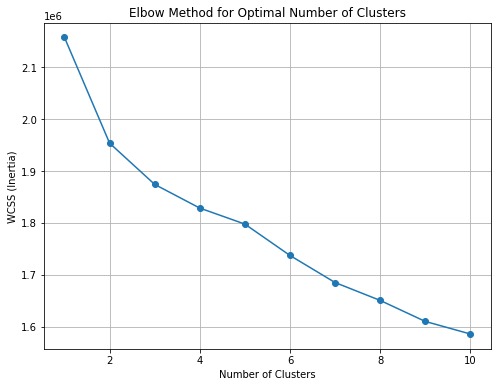

In [13]:
scaler_kmeans = StandardScaler()
train_data_scaled = scaler_kmeans.fit_transform(data_clean)

# Compute WCSS for different cluster numbers
wcss = []
max_clusters = 10  # You can adjust this to test more cluster sizes

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.grid()
plt.show()

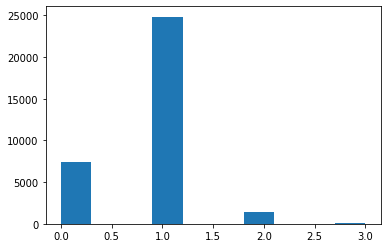

In [14]:
scaler_kmeans = StandardScaler()
data_scaled = scaler_kmeans.fit_transform(data_clean)
kmeans = KMeans(n_clusters=4, random_state=42).fit(data_scaled)
clusters_kmeans = kmeans.predict(data_scaled)
data_kmeans = data_clean.copy()
data_kmeans["group"]=clusters_kmeans
plt.hist(clusters_kmeans)
plt.show()

In [15]:
clusters_kmeans

array([1, 0, 0, ..., 1, 1, 1])

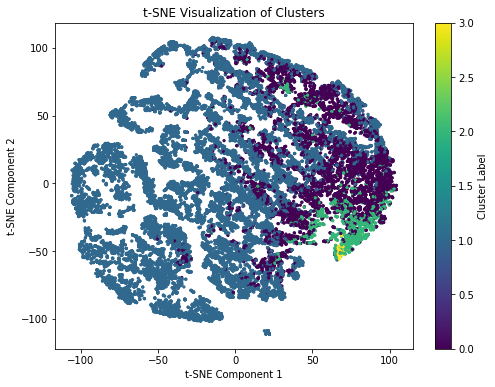

In [41]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters_kmeans, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Strategy 2: Spectral clustering

Preparations

In [42]:
n_neighbors = 1000
knn_graph = kneighbors_graph(data_clean, n_neighbors=n_neighbors, include_self=False)
affinity_matrix = 0.5 * (knn_graph + knn_graph.T)
L, diag = laplacian(affinity_matrix, normed=True, return_diag=True)
n_components = max_clusters if max_clusters is not None else 10
eigenvalues, eigenvectors = eigsh(L, k=n_components, which='SM')
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

Determine the optimal number of clusters using the eigenvalues

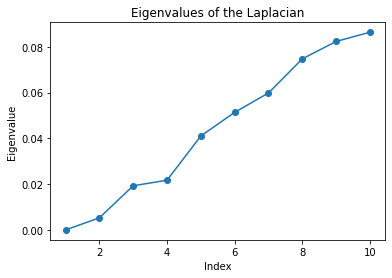

Optimal number of clusters: 4


In [43]:
if max_clusters is None:
    max_clusters = min(10, len(eigenvalues))

eigenvalues_sorted = np.sort(eigenvalues)
gaps = np.diff(eigenvalues_sorted[:max_clusters])
n_clusters = np.argmax(gaps) + 1

# Plot eigenvalues to visualize the gap
plt.figure()
plt.plot(range(1, max_clusters + 1), eigenvalues_sorted[:max_clusters], marker='o')
plt.title('Eigenvalues of the Laplacian')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

print(f"Optimal number of clusters: {n_clusters}")

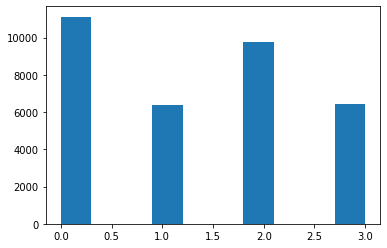

In [44]:
# Step 5: Use the first `n_clusters` eigenvectors to cluster
embedding = eigenvectors[:, :n_clusters]
# Normalize rows of the embedding
embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
# Step 6: Apply KMeans to the embedding
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters_spectral = kmeans.fit_predict(embedding)
data_spectral = data_clean.copy()
data_spectral["group"]=clusters_spectral
plt.hist(clusters_spectral)
plt.show()

In [ ]:
data_spectral[data_spectral["group"]==2]# 32045

,r,f,m,tof,Ffiction1,Fclassics3,Fcartoons5,Flegends6,Fphilosophy7,Freligion8,...,Mcooking36,Mlearning37,MGamesRiddles38,Msports39,Mhobby40,Mnature41,Mencyclopaedia44,Mvideos50,Mnonbooks99,group
0,194,7,318.894775,1703,1,0,1,0,0,0,...,10.174706,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,3,14,368.052246,2364,1,0,2,0,0,0,...,0.000000,22.749985,0.000000,0.0,61.176025,17.150269,10.000000,0.000000,0.000000,2
4,194,6,442.638184,2188,0,0,1,0,3,1,...,0.000000,7.949997,0.000000,0.0,17.895203,0.000000,0.000000,61.799988,0.000000,2
6,383,3,52.399658,2186,0,0,0,0,0,0,...,0.000000,0.000000,9.949997,0.0,0.000000,15.313187,0.000000,0.000000,0.000000,2
7,80,7,119.282043,2063,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30865,10,19,1110.807617,1202,6,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2
31799,65,29,1819.791992,737,1,0,0,0,0,0,...,0.000000,35.849976,0.000000,0.0,7.949997,192.149902,270.799805,0.000000,0.000000,2
32020,663,3,2071.984375,1056,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.0,30.047134,0.000000,1999.150391,0.000000,0.000000,2
32045,16,29,2243.660156,1042,0,0,0,0,2,3,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,25.849991,217.799927,0.000000,2


In [98]:
30/39*89

68.46153846153847

In [45]:
data_spectral.to_csv("data_with_clusters_spectral.csv",index=False)

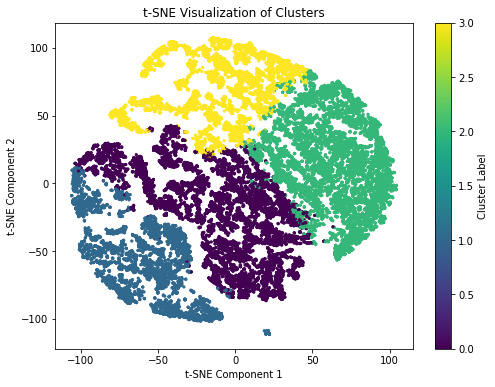

In [46]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters_spectral, cmap='viridis', s=5)
plt.colorbar(scatter, label='Cluster Label')
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Recommendations

## Collaborative Filtering

*Currently recommend purely based on maximizing money spent.*

### 1. Customer Segmentation of K-means

Calculate K nearest neighborhood

In [47]:
reader = Reader(rating_scale=(0, get_FM_data(data_clean,"M").max().max())) 
res_data_list = []
for i in data_kmeans["group"].unique().tolist():
    res = {}
    print(i)
    data_reco = wide_to_long(get_FM_data(data_clean[data_kmeans["group"]==i],"M"))
    data_reco=data_reco[data_reco["rating"]>0]
    data_surprise = Dataset.load_from_df(
        data_reco, reader
        )
    trainset, testset = train_test_split(data_surprise, test_size=0.2)
    print("Train & Test Split Complete.")
    sim_options = {
        'name': 'pearson',           
        'user_based': False, 
    }
    algo = KNNBasic(sim_options=sim_options,k=3)
    algo.fit(trainset)
    print("Algo Fitted")
    predictions = algo.test(testset)
    pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions],
                        columns=['user_id', 'item_id', 'rating'])
    top_n = pred_df.groupby('user_id', group_keys=False).apply(
        lambda x: x.nlargest(3, 'rating')
    ).reset_index(drop=True)
    real_test_data=pd.DataFrame(testset,columns=['user_id', 'item_id',"actual_spending"])
    res["recommendation"] = top_n
    res["real"]=real_test_data
    res_data_list.append(res) 

1
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2636771631.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


0
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2636771631.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


2
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted
3
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2636771631.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(
C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2636771631.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


In [48]:
new_rev_all_cluster = 0
old_rev_all_cluster=0
total_rev_all_cluster=0
for i in range(4):
    print(f"For cluster {data_kmeans['group'].unique().tolist()[i]}")
    res = res_data_list[i]
    top_n = res["recommendation"]
    real_test_data=res["real"]
    pred = top_n[["user_id","item_id"]].merge(real_test_data,on=["user_id","item_id"])
    total_rev = real_test_data["actual_spending"].sum()
    new_rev = pred["actual_spending"].sum()
    print("Total Revenue: ",total_rev)
    print("Revenue captured by new recommendations:",new_rev)
    print(f"Percentage of understanding: {round(new_rev/total_rev*100)}%")

    base_line_items = [ "history19","conthist20","health35" ,"classics3"] 
    base_line = real_test_data[real_test_data["item_id"].isin(base_line_items)]
    old_rev = base_line["actual_spending"].sum()
    print("Revenue captured by old recommendations:",old_rev)
    print(f"Percentage of understanding: {round(old_rev/total_rev*100)}%")
    print("")

    new_rev_all_cluster+=new_rev
    old_rev_all_cluster+=old_rev
    total_rev_all_cluster+=total_rev

print("Total Revenue: ",total_rev_all_cluster)
print("Revenue captured by new recommendations:",new_rev_all_cluster)
print(f"Percentage of understanding: {round(new_rev_all_cluster/total_rev_all_cluster*100)}%")
print("Revenue captured by old recommendations:",old_rev_all_cluster)
print(f"Percentage of understanding: {round(old_rev_all_cluster/total_rev_all_cluster*100)}%")

For cluster 1
Total Revenue:  430648.44785298797
Revenue captured by new recommendations: 424512.4302863235
Percentage of understanding: 99%
Revenue captured by old recommendations: 173499.8520924584
Percentage of understanding: 40%

For cluster 0
Total Revenue:  605152.699634486
Revenue captured by new recommendations: 554211.6592178164
Percentage of understanding: 92%
Revenue captured by old recommendations: 249738.92462360847
Percentage of understanding: 41%

For cluster 2
Total Revenue:  329156.7817909828
Revenue captured by new recommendations: 268677.41144586436
Percentage of understanding: 82%
Revenue captured by old recommendations: 126735.18162164059
Percentage of understanding: 39%

For cluster 3
Total Revenue:  70120.4801015584
Revenue captured by new recommendations: 50371.189323448096
Percentage of understanding: 72%
Revenue captured by old recommendations: 28392.4215315635
Percentage of understanding: 40%

Total Revenue:  1435078.409380015
Revenue captured by new recommen

### 2. Customer Segmentation of Spectral Clustering

In [49]:
reader = Reader(rating_scale=(0, get_FM_data(data_clean,"M").max().max())) 
res_data_list = []
for i in data_spectral["group"].unique().tolist():
    res = {}
    print(i)
    data_reco = wide_to_long(get_FM_data(data_clean[data_spectral["group"]==i],"M"))
    data_reco=data_reco[data_reco["rating"]>0]
    data_surprise = Dataset.load_from_df(
        data_reco, reader
        )
    trainset, testset = train_test_split(data_surprise, test_size=0.2)
    print("Train & Test Split Complete.")
    sim_options = {
        'name': 'pearson',           
        'user_based': False, 
    }
    algo = KNNBasic(sim_options=sim_options,k=3)
    algo.fit(trainset)
    print("Algo Fitted")
    predictions = algo.test(testset)
    pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in predictions],
                        columns=['user_id', 'item_id', 'rating'])
    top_n = pred_df.groupby('user_id', group_keys=False).apply(
        lambda x: x.nlargest(3, 'rating')
    ).reset_index(drop=True)
    real_test_data=pd.DataFrame(testset,columns=['user_id', 'item_id',"actual_spending"])
    res["recommendation"] = top_n
    res["real"]=real_test_data
    res_data_list.append(res)

2
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2967497739.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


3
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2967497739.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


0
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2967497739.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


1
Train & Test Split Complete.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Algo Fitted


C:\Users\HuangZimeng\AppData\Local\Temp\ipykernel_18188\2967497739.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n = pred_df.groupby('user_id', group_keys=False).apply(


In [73]:
new_rev_all_cluster = 0
old_rev_all_cluster=0
total_rev_all_cluster=0
bar_list = []
for i in range(4):
    print(f"For cluster {data_spectral['group'].unique().tolist()[i]}")
    res = res_data_list[i]
    top_n = res["recommendation"]
    real_test_data=res["real"]
    pred = top_n[["user_id","item_id"]].merge(real_test_data,on=["user_id","item_id"])
    total_rev = real_test_data["actual_spending"].sum()
    new_rev = pred["actual_spending"].sum()
    print("Total Revenue: ",total_rev)
    print("Revenue captured by new recommendations:",new_rev)
    print(f"Percentage of understanding: {round(new_rev/total_rev*100)}%")
    bar_list.append({"Cluster":i+1,"Version":"New Algorithm","recall":new_rev/total_rev*100})
    

    base_line_items = [ "history19","conthist20","health35" ,"classics3"] 
    base_line = real_test_data[real_test_data["item_id"].isin(base_line_items)]
    old_rev = base_line["actual_spending"].sum()
    print("Revenue captured by old recommendations:",old_rev)
    print(f"Percentage of understanding: {round(old_rev/total_rev*100)}%")
    bar_list.append({"Cluster":i+1,"Version":"Old strategy","recall":old_rev/total_rev*100})
    

    new_rev_all_cluster+=new_rev
    old_rev_all_cluster+=old_rev
    total_rev_all_cluster+=total_rev

    print("New recall:",len(pred)/len(real_test_data))
    print("Old recall:",sum(real_test_data["item_id"].isin(base_line_items))/len(real_test_data))
    
    print("")

print("Total Revenue: ",total_rev_all_cluster)
print("Revenue captured by new recommendations:",new_rev_all_cluster)
print(f"Percentage of understanding: {round(new_rev_all_cluster/total_rev_all_cluster*100)}%")
print("Revenue captured by old recommendations:",old_rev_all_cluster)
print(f"Percentage of understanding: {round(old_rev_all_cluster/total_rev_all_cluster*100)}%")

For cluster 2
Total Revenue:  925123.1695014741
Revenue captured by new recommendations: 790553.2000819048
Percentage of understanding: 85%
Revenue captured by old recommendations: 367759.6142808774
Percentage of understanding: 40%
New recall: 0.8534901559703401
Old recall: 0.24193300946049603

For cluster 3
Total Revenue:  156497.9653757951
Revenue captured by new recommendations: 149738.03044309892
Percentage of understanding: 96%
Revenue captured by old recommendations: 57947.0753059111
Percentage of understanding: 37%
New recall: 0.9600335852225022
Old recall: 0.28984047019311504

For cluster 0
Total Revenue:  282200.6892769229
Revenue captured by new recommendations: 269267.624764678
Percentage of understanding: 95%
Revenue captured by old recommendations: 111769.1594675078
Percentage of understanding: 40%
New recall: 0.9486761320030699
Old recall: 0.29029163468917885

For cluster 1
Total Revenue:  73320.7786957023
Revenue captured by new recommendations: 72213.3605123767
Percenta

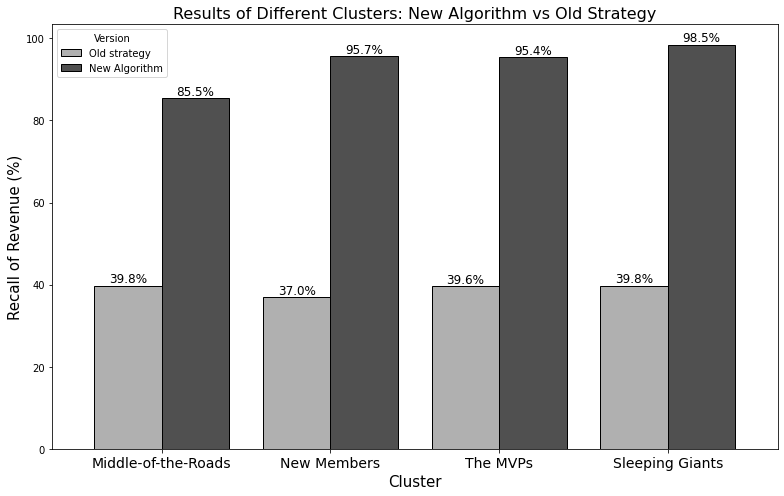

In [90]:
bar_df = pd.DataFrame(bar_list)

# Group the data and reorder columns to have 'Old strategy' first
import matplotlib.pyplot as plt
import pandas as pd

# Group the data and reorder columns to have 'Old strategy' first
bar_df_grouped = bar_df.pivot(index="Cluster", columns="Version", values="recall")
bar_df_grouped = bar_df_grouped[["Old strategy", "New Algorithm"]]  # Ensure 'Old strategy' is on the left

# Rename the clusters
bar_df_grouped.index = ["Middle-of-the-Roads", "New Members", "The MVPs", "Sleeping Giants"]

# Define grey shades for both versions
colors = ["#B0B0B0", "#505050"]  # Light grey for Old strategy, dark grey for New Algorithm

# Plot the grouped bar chart
ax = bar_df_grouped.plot(
    kind="bar", 
    figsize=(11, 7), 
    color=colors, 
    edgecolor="black", 
    width=0.8  # Adjust bar width
)

# Annotate percentages on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=12)

# Add labels, title, and legend
plt.xlabel("Cluster", fontsize=15)
plt.ylabel("Recall of Revenue (%)", fontsize=15)
plt.title("Results of Different Clusters: New Algorithm vs Old Strategy", fontsize=16)
plt.xticks(rotation=0, fontsize=14)  # Keep cluster labels horizontal
plt.legend(["Old strategy", "New Algorithm"], title="Version", fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()
